# Numerai Auxiliary Feature EDA

---
## Load libraries

In [53]:
# libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from numerapi import NumerAPI
from utils.utils import ERA_COL, TARGET_COL
import gc


In [54]:
# see current round
napi = NumerAPI()
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 316


---
## Load training and validation data

In [55]:
# read training data
with open("data/features.json", "r") as f:
    feature_metadata = json.load(f)
features = list(feature_metadata["feature_stats"].keys())
read_columns = features + [ERA_COL, TARGET_COL]

training = pd.read_parquet('data/train.parquet', columns=read_columns)

---
# Compute era-wise feature-target correlations

In [78]:
# import sklearn kmeans
from sklearn.cluster import KMeans

In [76]:
# calculate feature-target corr for each sera
corr_list = []

for f in features:
    corr = training.groupby("era")[[f, TARGET_COL]].corr(method="spearman").unstack().iloc[:,1]
    corr_list.append(corr)

In [174]:
# concat to a single df
corr_df = pd.concat(corr_list, axis=1)
corr_df.columns = features

In [175]:
# create corr by features
fcorr_df = corr_df.T

---
# Find optimal K for K-Means clustering

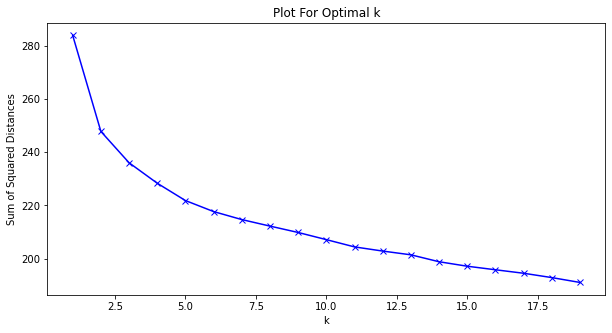

In [176]:
# instantiate clustering
K = 20
ssdist_0 = []
for k in range(1, K):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(corr_df)
    ssdist_0.append(kmeans.inertia_)

# plot inertia
plt.figure(figsize=(10, 5))
plt.plot(range(1, K), ssdist_0, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Plot For Optimal k')
plt.show()

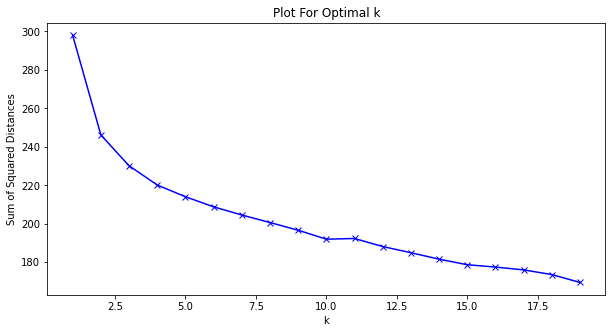

In [177]:
# instantiate clustering
K = 20
ssdist_1 = []
for k in range(1, K):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(fcorr_df)
    ssdist_1.append(kmeans.inertia_)

# plot inertia
plt.figure(figsize=(10, 5))
plt.plot(range(1, K), ssdist_1, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Plot For Optimal k')
plt.show()

In [178]:
# free up memory
gc.collect()

6032

---
# Find optimal Epsilon for DBSCAN clustering

In [98]:
# import sklearn dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

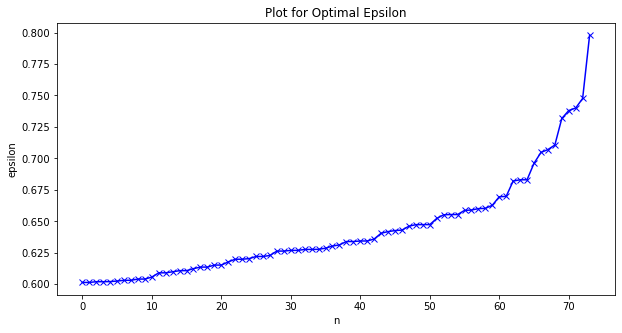

In [179]:
# compute distances
neighbors_0 = NearestNeighbors(n_neighbors=20)
neighbors_fit_0 = neighbors_0.fit(corr_df)
distances_0, indices_0 = neighbors_fit_0.kneighbors(corr_df)
distances_0 = np.sort(distances_0, axis=0)
distances_0 = distances_0[:,1]

plt.figure(figsize=(10, 5))
plt.plot(distances_0[500:], 'bx-')
plt.xlabel('n')
plt.ylabel('epsilon')
plt.title('Plot for Optimal Epsilon')
plt.show()

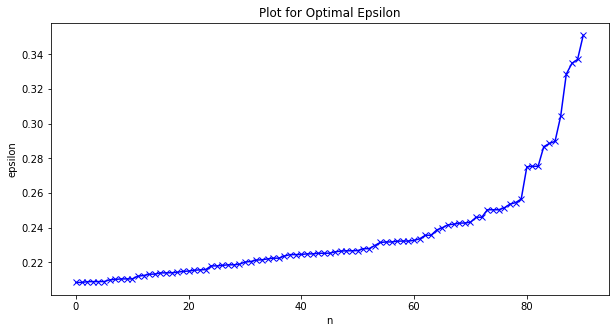

In [185]:
# compute distances
neighbors_1 = NearestNeighbors(n_neighbors=20)
neighbors_fit_1 = neighbors_1.fit(fcorr_df)
distances_1, indices_1 = neighbors_fit_1.kneighbors(fcorr_df)
distances_1 = np.sort(distances_1, axis=0)
distances_1 = distances_1[:,1]

plt.figure(figsize=(10, 5))
plt.plot(distances_1[1100:], 'bx-')
plt.xlabel('n')
plt.ylabel('epsilon')
plt.title('Plot for Optimal Epsilon')
plt.show()

In [186]:
# free up memory
gc.collect()

21421

---
# Compute clusters via DBSCAN

In [190]:
# perform clustering
model_0 = DBSCAN(eps=0.675, min_samples=7)
model_0.fit(corr_df)
cluster_0 = model_0.labels_

pd.DataFrame(cluster_0).groupby(0).size()

0
-1    283
 0    281
 1      5
 2      5
dtype: int64

In [204]:
# perform clustering
model_1 = DBSCAN(eps=0.25, min_samples=10)
model_1.fit(fcorr_df)
cluster_1 = model_1.labels_

pd.DataFrame(cluster_1).groupby(0).size()

0
-1    1065
 0      34
 1      10
 2      10
 3      10
 4      10
 5      10
 6      12
 7      10
 8      10
 9      10
dtype: int64